<h2 align="center">Лабораторна робота №2</h2>
<h5 align="center"><i>Роботу виконала студентка групи ФІ-21, Денисенко Анастасія</i></h5>
<p><b>Тема роботи:</b> "«Базові методи й алгоритми ройового інтелекту, їх застосування для знаходження глобальних екстремумів багатовимірних функцій дійсної змінної".</p>
<p><b>Мета роботи:</b> опанувати принципи роботи наведених у роботі алгоритмів ройового інтелекту (алгоритм оптимізації роєм частинок, бджолиний алгоритм оптимізації, світлячковий алгоритм оптимізації), опис яких наведено у даній роботі. Розробити відповідне програмне забезпечення знаходження глобаних екстремумів функцій у задачах умовної й безумовної багатовимірної онокритеріальної оптимізації.</p>

### Завдання до лабораторної роботи

1. Ознайомитись з теоретичними відомостями до кожного з розглянутих алгоритмів (алгоритм оптимізації роєм частинок, бджолиний алгоритм оптимізації, алгоритм оптимізації роєм світлячків).
2. Розробити програмне забезпечення (мова програмування і середовище розробки за вибором студента) для текстування описаних вище алгоритмів для знаходження глобального екстремуму функції Растринга (безумовна оптимізація, підрозділ 4.1 даної роботи). Взяти розмірність задачі $n=2, n=5, n=10, n=15$. Подати результати тестування у вигляді графіків, як у попередній роботі. Кількість запусків програмного застосунку для 3-х алгоритмів будь-яке (на вибір студента).
3. Модифікувати програми так (для трьох алгоритів), щоб можна було бачити процес пошуку глобального екстремуму функцій з обмеженнями, які наведені далі у 4-му розділі даної роботи. Взяти дві на вибір функції. Показати динаміку збіжності кожного з методів на поставлених задачах.
4. Модифікувати програми для вирішення прикладного завдання (трьома алгоритмами), оптимізаційна математична модель якого наведена у підрозділі 5.1 даної роботи. Подати результати так само, як для завдання з попереднього пункту.
5. Адаптувати програми для вирішення прикладного завдання (трьома алгоритмами), оптимізаційна математична модель якого наведена у підрозділі 5.2 даної роботи. Подати результати так само, як для завдання з попереднього пункту.
6. Зробити висновки до отриманих результатів
7. Захистити лабораторну роботу у викладача

In [4]:
import random
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from matplotlib.ticker import LinearLocator
from copy import deepcopy
from functions import mishra_bird, rastrigin, Rosenbrock, erkli

In [6]:
class PSO(object):
    def __init__(self, func, num_iter, a1, a2, size_pop, v_min, v_max, x_min, x_max, y_min, y_max, minimize = True):
        if a1 < 0 or a1 > 4 or a2 < 0 or a2 > 4:
            raise ValueError("Accelerations has to be in range (0, 4), but given values are {i} and {j}".format(i = a1, j = a2))
        if v_max <= 0:
            raise ValueError("Maximum velocity has to be greater than 0, but given value is {i}".format(i = v_max))
        self.func = func
        self.num_iter = num_iter
        self.a1 = a1
        self.a2 = a2
        self.size_pop = size_pop
        self.v_min = v_min
        self.v_max = v_max
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.minimize = minimize
        self.curr_iter = 0
        self.pop_x, self.pop_y, self.pop_z = self.create_first_population()
        self.x_bests = np.full((self.size_pop, self.size_pop), self.x_min)
        self.y_bests = np.full((self.size_pop, self.size_pop), self.y_min)
        self.z_bests = np.full((self.size_pop, self.size_pop), self.func(self.x_min, self.y_min))
        self.x_ideal, self.y_ideal, self.z_ideal = self.x_min, self.y_min, self.func(self.x_min, self.y_min)
        self.vel_x, self.vel_y = self.create_velocity_vector()
        self.diff_x = abs(self.x_max) + abs(self.x_min)
        self.diff_y = abs(self.y_max) + abs(self.y_min)
    def put_in_boundry(self, i, j, x = True):
        if x == True: 
            if self.pop_x[-1][i][j] <= self.x_min or self.pop_x[-1][i][j] >= self.x_max:
                self.vel_x[i][j] *= -1
                self.pop_x[-1][i][j] =  ((self.pop_x[-1][i][j] - self.x_min) % self.diff_x + self.diff_x) % self.diff_x + self.x_min
        else:
            if self.pop_y[-1][i][j] <= self.y_min or self.pop_y[-1][i][j] >= self.y_max:
                self.vel_x[i][j] *= -1
                self.pop_y[-1][i][j] = ((self.pop_y[-1][i][j] - self.y_min) % self.diff_y + self.diff_y) % self.diff_y + self.y_min

    def in_boundry(self, sworm, x=True):
        if x == True:
            if sworm >= self.x_min and sworm <= self.x_max:
                return True
            else:
                False
        else:
            if sworm >= self.y_min and sworm <= self.y_max:
                return True
            else:
                return False
    def create_first_population(self):
        self.pop_x = []
        self.pop_y = []
        stp_x = abs((self.x_min - self.x_max))/self.size_pop
        stp_y = abs((self.y_min - self.y_max))/self.size_pop
        p_x, p_y = np.arange(self.x_min, self.x_max, stp_x), np.arange(self.y_min, self.y_max, stp_y)
        p_x, p_y = np.meshgrid(p_x, p_y)
        p_x, p_y = p_x.tolist(), p_y.tolist()
        self.pop_x.append(list(p_x))
        self.pop_y.append(list(p_y))
        self.pop_z = deepcopy(self.pop_x)
        for i in range(self.size_pop):
            for j in range(self.size_pop):
                self.pop_z[-1][i][j] = self.func(self.pop_x[-1][i][j], self.pop_y[-1][i][j])
        return self.pop_x, self.pop_y, self.pop_z
    def find_fitness(self):
        if self.minimize == True:
            for i in range(self.size_pop):
                for j in range(self.size_pop):
                    if self.func(self.pop_x[-1][i][j], self.pop_y[-1][i][j]) < self.func(self.x_bests[i][j], self.y_bests[i][j]):
                        self.x_bests[i][j] = self.pop_x[-1][i][j]
                        self.y_bests[i][j] = self.pop_y[-1][i][j]
                        self.z_bests[i][j] = self.func(self.x_bests[i][j], self.y_bests[i][j])
                        if self.func(self.pop_x[-1][i][j], self.pop_y[-1][i][j]) < self.z_ideal and self.in_boundry(self.pop_x[-1][i][j], True) == True and self.in_boundry(self.pop_y[-1][i][j], False) == True:
                            self.x_ideal = self.pop_x[-1][i][j]
                            self.y_ideal = self.pop_y[-1][i][j]
                            self.z_ideal = self.func(self.x_ideal, self.y_ideal)
        else:
            for i in range(self.size_pop):
                for j in range(self.size_pop):
                    if self.func(self.pop_x[-1][i][j], self.pop_y[-1][i][j]) > self.func(self.x_bests[i][j], self.y_bests[i][j]):
                        self.x_bests[i][j] = self.pop_x[-1][i][j]
                        self.y_bests[i][j] = self.pop_y[-1][i][j]
                        self.z_bests[i][j] = self.func(self.x_bests[i][j], self.y_bests[i][j])
                        if self.func(self.pop_x[-1][i][j], self.pop_y[-1][i][j]) > self.z_ideal and self.pop_x[-1][i][j] >= self.x_min and self.pop_x[-1][i][j] <= self.x_max and self.pop_y[-1][i][j] >= self.y_min and self.pop_y[-1][i][j] <= self.y_max:
                            self.x_ideal = self.pop_x[-1][i][j]
                            self.y_ideal = self.pop_y[-1][i][j]
                            self.z_ideal = self.func(self.x_ideal, self.y_ideal)
        return self.x_bests, self.y_bests, self.z_bests, self.x_ideal, self.y_ideal, self.z_ideal
    def create_velocity_vector(self):
        if self.curr_iter == 0:
            self.vel_x, self.vel_y = [], []
            for i in range(self.size_pop):
                tmp_x = []
                tmp_y = []
                for j in range(self.size_pop):
                    tmp_x.append(self.v_min + (self.v_max - self.v_min)*random.uniform(0, 1))
                    tmp_y.append(self.v_min + (self.v_max - self.v_min)*random.uniform(0, 1))
                self.vel_x.append(tmp_x)
                self.vel_y.append(tmp_y)
        else:
            r1 = np.random.rand()
            r2 = np.random.rand()
            for i in range(self.size_pop):
                for j in range(self.size_pop):
                    self.vel_x[i][j] += self.a1*(self.x_bests[i][j]-self.pop_x[-1][i][j])*r1 + self.a2*(self.x_ideal - self.pop_x[-1][i][j])*r2
                    self.vel_y[i][j] += self.a1*(self.y_bests[i][j]-self.pop_y[-1][i][j])*r1 + self.a2*(self.y_ideal - self.pop_y[-1][i][j])*r2
        return self.vel_x, self.vel_y
    def update_positions(self):
        self.pop_x.append(self.pop_x[-1])
        self.pop_y.append(self.pop_y[-1])
        self.pop_z.append(self.pop_z[-1])
        for i in range(self.size_pop):
             for j in range(self.size_pop):
                self.pop_x[-1][i][j] += self.vel_x[i][j]
                self.pop_y[-1][i][j] += self.vel_y[i][j]
                self.put_in_boundry(i, j, True)
                self.put_in_boundry(i, j, False)
                self.pop_z[-1][i][j] = self.func(self.pop_x[-1][i][j], self.pop_y[-1][i][j])
        return self.pop_x[-1], self.pop_y[-1]
    def iter(self):
        self.find_fitness()
        self.create_velocity_vector()
        self.update_positions()
        self.curr_iter += 1
    def run(self):
        while self.curr_iter != self.num_iter:
            self.iter()
        return self.pop_x[-1], self.pop_y[-1], self.x_ideal, self.y_ideal, self.z_ideal
    def plot(self):
        self.run()
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        X, Y = np.arange(self.x_min, self.x_max, 0.01), np.arange(self.y_min, self.y_max, 0.01)
        X, Y = np.meshgrid(X, Y)
        Z = self.func(X, Y)
        surf = ax.plot_surface(X, Y, Z, cmap=matplotlib.cm.viridis, linewidth=0, antialiased=False, alpha=0.25)
        ax.set_zlim(Z.min(), Z.max())
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter('{x:.02f}')
        ax.scatter(self.x_ideal, self.y_ideal, self.z_ideal, c = 'orchid')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    def run_and_plot(self):
        X, Y = np.arange(self.x_min, self.x_max, 0.01), np.arange(self.y_min, self.y_max, 0.01)
        X, Y = np.meshgrid(X, Y)
        Z = self.func(X, Y)
        def update_graph(num):
            self.iter()
            for i in range(self.size_pop):
                all_pop._offsets3d = (self.pop_x[-1][i], self.pop_y[-1][i], self.pop_z[-1][i])
                best._offsets3d = ([self.x_ideal], [self.y_ideal], [self.func(self.x_ideal, self.y_ideal)])
            title.set_text('PSO, iteration {}'.format(num+1))
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        title = ax.set_title('PSO')
        all_pop = ax.scatter(np.concatenate(self.pop_x[0]), np.concatenate(self.pop_y[0]), np.concatenate(self.pop_z[0]), c = 'cornflowerblue', zorder = 1)
        best = ax.scatter([self.x_min], [self.y_min], [self.func(self.x_min, self.y_min)], c = 'orchid', zorder = 1)
        surf = ax.plot_surface(X, Y, Z, cmap = matplotlib.cm.viridis, linewidth=0, antialiased = False, alpha=0.25)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, self.num_iter, interval=60, blit=False, repeat=False)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axes.set_xlim3d(left=self.x_min, right=self.x_max)
        ax.axes.set_ylim3d(bottom=self.y_min, top=self.y_max) 
        plt.show()

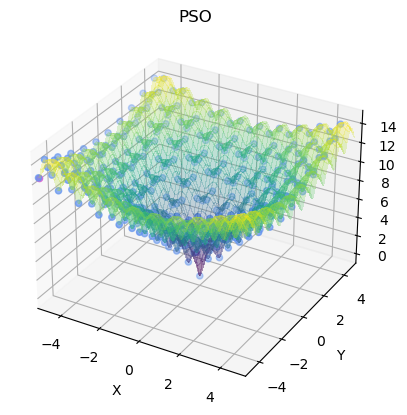

/Users/anastasiiadenysenko/anaconda3/lib/python3.11/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [8]:
p = PSO(erkli, 50, 2, 2, 20, -1, 3, -5, 5, -5, 5, minimize = True)
p.run_and_plot()

In [10]:
class Bees:
    def __init__(self, func, delta, n_max, alpha, num_iter, size_pop, num_ar, num_el_ar, num_fl_el, num_fl, x_min, x_max, y_min, y_max, minimize = True):
        if delta > 1 or delta < 0:
            raise ValueError("Value for delta gas to be in range (0, 1), but given value is {i}".format(i = delta))
        if n_max > 1 or n_max < 0:
            raise ValueError("Value for n_max gas to be in range (0, 1), but given value is {i}".format(i = n_max))
        if alpha > 1 or alpha < 0:
            raise ValueError("Value for alpha gas to be in range (0, 1), but given value is {i}".format(i = alpha))
        self.func = func
        self.delta = delta
        self.n_max = n_max
        self.alpha = alpha
        self.num_iter = num_iter
        self.size_pop = size_pop
        self.num_ar = num_ar
        self.num_el_ar = num_el_ar
        self.num_fl_el = num_fl_el
        self.num_fl = num_fl
        self.x_min =  x_min
        self.x_max = x_max
        self.y_min =  y_min
        self.y_max = y_max
        self.minimize = minimize
        self.pop_x, self.pop_y = self.create_first_population()
        self.x_perfect, self.y_perfect, _,  _ = self.find_fitness_and_sort()
        self.curr_iter = 0
    def create_first_population(self):
        p_x, p_y = [], []
        for i in range(self.size_pop):
            p_x.append(self.x_min + (self.x_max - self.x_min)*random.uniform(0, 1))
            p_y.append(self.y_min + (self.y_max - self.y_min)*random.uniform(0, 1))
        self.pop_x = np.array(p_x)
        self.pop_y = np.array(p_y)
        self.pop_x, self.pop_y = np.meshgrid(self.pop_x, self.pop_y)
        return self.pop_x, self.pop_y
    def find_fitness_and_sort(self):
        pop_x = {}
        pop_y = {}
        for i in range(self.size_pop):
            for j in range(self.size_pop):
                pop_x[self.pop_x[i][j]] = self.func(self.pop_x[i][j], self.pop_y[i][j])
                pop_y[self.pop_y[i][j]] = self.func(self.pop_x[i][j], self.pop_y[i][j])
        pop_x = sorted(pop_x.items(), key = lambda x:x[1], reverse = not self.minimize)
        pop_y = sorted(pop_y.items(), key = lambda x:x[1], reverse = not self.minimize)
        res_x = [ item[0] for item in pop_x ]
        res_y = [ item[0] for item in pop_y ]
        self.pop_x = np.array(res_x)
        self.pop_y = np.array(res_y)
        self.pop_x, self.pop_y = np.meshgrid(self.pop_x, self.pop_y)
        self.x_perfect =  self.pop_x[0][0]
        self.y_perfect =  self.pop_y[0][0]
        return self.x_perfect, self.y_perfect, self.pop_x, self.pop_y
    def iter(self):
        self.curr_iter += 1
        for i in range(self.num_ar): 
            n_n = self.n_max*self.alpha**self.curr_iter
            if i <= self.num_el_ar:
                z = self.num_fl_el
            else:
                z = self.num_fl
            for j in range(z):
                for k in range(z):
                    self.pop_x[j][k] += n_n*self.delta*(self.x_max - self.x_min)*(-1+2*random.uniform(0, 1))
                    self.pop_y[j][k] += n_n*self.delta*(self.y_max - self.y_min)*(-1+2*random.uniform(0, 1))
                    if self.pop_x[j][k] > self.x_max:
                        self.pop_x[j][k] = self.x_max
                    elif self.pop_x[j][k] < self.x_min:
                        self.pop_x[j][k] = self.x_min
                    if self.pop_y[j][k] > self.y_max:
                        self.pop_y[j][k] = self.y_max
                    elif self.pop_y[j][k] < self.y_min:
                        self.pop_y[j][k] = self.y_min
        for m in range(self.num_ar, self.size_pop):
            for n in range(self.num_ar, self.size_pop):
                self.pop_x[m][n] = self.x_min + (self.x_max - self.x_min)*random.uniform(0, 1)
                self.pop_y[m][n] = self.y_min + (self.y_max - self.y_min)*random.uniform(0, 1)
        return self.pop_x, self.pop_y
    def run(self):
        for _ in range(self.num_iter):
            self.iter()
            self.find_fitness_and_sort()
        return self.x_perfect, self.y_perfect
    def plot(self):
        self.run()
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        X, Y = np.arange(self.x_min, self.x_max, 0.01), np.arange(self.y_min, self.y_max, 0.01)
        X, Y = np.meshgrid(X, Y)
        Z = self.func(X, Y)
        surf = ax.plot_surface(X, Y, Z, cmap=matplotlib.cm.viridis, linewidth=0, antialiased=False, alpha=0.25)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter('{x:.02f}')
        ax.scatter(self.x_perfect, self.y_perfect, self.func(self.x_perfect, self.y_perfect), c = 'orchid')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    def run_and_plot(self):
        X, Y = np.arange(self.x_min, self.x_max, 0.01), np.arange(self.y_min, self.y_max, 0.01)
        X, Y = np.meshgrid(X, Y)
        Z = self.func(X, Y)
        def update_graph(num):
            self.iter()
            for i in range(self.size_pop):
                pop_z = []
                for j in range(self.size_pop):
                    pop_z.append(self.func(self.pop_x[i][j], self.pop_y[i][j]))
                all_pop._offsets3d = (self.pop_x[i], self.pop_y[i], pop_z)
            best._offsets3d = ([self.x_perfect], [self.y_perfect], [self.func(self.x_perfect, self.y_perfect)])
            title.set_text('Bees, iteration {}'.format(num+1))
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        title = ax.set_title('Bees')
        all_pop = ax.scatter(self.pop_x[0], self.pop_y[0], self.func(self.pop_x, self.pop_y)[0], c = 'cornflowerblue', zorder = 1)
        best = ax.scatter([self.x_min], [self.y_min], [self.func(self.x_min, self.y_min)], c = 'orchid', zorder = 1)
        surf = ax.plot_surface(X, Y, Z, cmap = matplotlib.cm.viridis, linewidth=0, antialiased = False, alpha=0.25)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, self.num_iter, interval=60, blit=False, repeat=False)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axes.set_xlim3d(left=self.x_min, right=self.x_max)
        ax.axes.set_ylim3d(bottom=self.y_min, top=self.y_max) 
        plt.show()

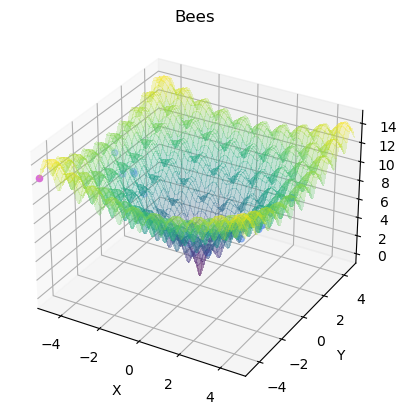

In [16]:
b = Bees(erkli, 0.15, 0.34, 0.72, 50, 16, 3, 10, 5, 2, -5, 5, -5, 5, minimize = True)
b.run_and_plot()

In [18]:
class Fireflies:
    def __init__(self, func, beta_max, gamma, alpha, max_iter, size_pop, x_min, x_max, y_min, y_max, minimize = True):
        if beta_max <= 0 or beta_max >= 1:
            raise ValueError("Beta_max has to be in range (0, 1), but given value is {i}".format(i = beta_max))
        if gamma <= 0 or gamma >= 1:
            raise ValueError("Gamma has to be in range (0, 1), but given value is {i}".format(i = gamma))
        if alpha < 0 or alpha > 1:
            raise ValueError("Alpha has to be in range [0, 1], but given value is {i}".format(i = alpha))
        self.func = func
        self.beta_max = beta_max
        self.gamma = gamma
        self.alpha = alpha
        self.max_iter = max_iter
        self.size_pop = size_pop
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.minimize = minimize
        self.pop_x, self.pop_y = self.create_first_population()
        self.curr_iter = 0
        self.x_ideal = self.pop_x[0][0]
        self.y_ideal = self.pop_y[0][0]
    def create_first_population(self):
        p_x, p_y = [], []
        for i in range(self.size_pop):
            p_x.append(self.x_min + (self.x_max - self.x_min)*random.uniform(0, 1))
            p_y.append(self.y_min + (self.y_max - self.y_min)*random.uniform(0, 1))
        self.pop_x = np.array(p_x)
        self.pop_y = np.array(p_y)
        self.pop_x, self.pop_y = np.meshgrid(self.pop_x, self.pop_y)
        return self.pop_x, self.pop_y
    def iter(self):
        for i in range(self.size_pop):
            for j in range(self.size_pop):
                if self.func(self.pop_x[i][j], self.y_ideal) < self.func(self.x_ideal, self.y_ideal):
                    self.x_ideal = self.pop_x[i][j]
                if self.func(self.x_ideal, self.pop_y[i][j]) < self.func(self.x_ideal, self.y_ideal):
                    self.y_ideal = self.pop_y[i][j]
                for k in range(self.size_pop):
                    for m in range(self.size_pop):
                        if self.func(self.pop_x[i][j], self.y_ideal) < self.func(self.pop_x[k][m], self.y_ideal):
                            beta = self.beta_max*np.e**(-self.gamma*(self.pop_x[i][j] - self.pop_x[k][m])**2)
                            self.pop_x[k][m] += beta*(self.pop_x[i][j] - self.pop_x[k][m]) + self.alpha*(random.uniform(0, 1) - 0.5)
                            if self.pop_x[k][m] < self.x_min:
                                self.pop_x[k][m] = self.x_min
                            elif self.pop_x[k][m] > self.x_max:
                                self.pop_x[k][m] = self.x_max
                        if self.func(self.x_ideal, self.pop_y[i][j]) < self.func(self.x_ideal, self.pop_y[k][m]):
                            beta = self.beta_max*np.e**(-self.gamma*(self.pop_y[i][j] - self.pop_y[k][m])**2)
                            self.pop_y[k][m] += beta*(self.pop_y[i][j] - self.pop_y[k][m]) + self.alpha*(random.uniform(0, 1) - 0.5)
                            if self.pop_y[k][m] < self.y_min:
                                self.pop_y[k][m] = self.y_min
                            elif self.pop_y[k][m] > self.y_max:
                                self.pop_y[k][m] = self.y_max
        self.curr_iter += 1
        return self.pop_x, self.pop_y, self.x_ideal, self.y_ideal
    def run(self):
        while self.curr_iter != self.max_iter:
            self.iter()
        return self.pop_x, self.pop_y, self.x_ideal, self.y_ideal
    def plot(self):
        self.run()
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        X, Y = np.arange(self.x_min, self.x_max, 0.01), np.arange(self.y_min, self.y_max, 0.01)
        X, Y = np.meshgrid(X, Y)
        Z = self.func(X, Y)
        surf = ax.plot_surface(X, Y, Z, cmap=matplotlib.cm.viridis, linewidth=0, antialiased=False, alpha=0.25)
        ax.set_zlim(Z.min(), Z.max())
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter('{x:.02f}')
        ax.scatter(self.x_ideal, self.y_ideal, self.func(self.x_ideal, self.y_ideal), c = 'orchid')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    def run_and_plot(self):
        X, Y = np.arange(self.x_min, self.x_max, 0.01), np.arange(self.y_min, self.y_max, 0.01)
        X, Y = np.meshgrid(X, Y)
        Z = self.func(X, Y)
        def update_graph(num):
            self.iter()
            for i in range(self.size_pop):
                pop_z = []
                for j in range(self.size_pop):
                    pop_z.append(self.func(self.pop_x[i][j], self.pop_y[i][j]))
                all_pop._offsets3d = (self.pop_x[i], self.pop_y[i], pop_z)
            best._offsets3d = ([self.x_ideal], [self.y_ideal], [self.func(self.x_ideal, self.y_ideal)])
            title.set_text('Fireflies, iteration {}'.format(num+1))
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        title = ax.set_title('Fireflies')
        all_pop = ax.scatter(self.pop_x[0][0], self.pop_y[0][0], self.func(self.pop_x[0][0], self.pop_y[0][0]), c = 'cornflowerblue', zorder = 1)
        best = ax.scatter([self.x_min], [self.y_min], [self.func(self.x_min, self.y_min)], c = 'orchid', zorder = 1)
        surf = ax.plot_surface(X, Y, Z, cmap = matplotlib.cm.viridis, linewidth=0, antialiased = False, alpha=0.25)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, self.max_iter, interval=60, blit=False, repeat=False)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axes.set_xlim3d(left=self.x_min, right=self.x_max)
        ax.axes.set_ylim3d(bottom=self.y_min, top=self.y_max) 
        plt.show()

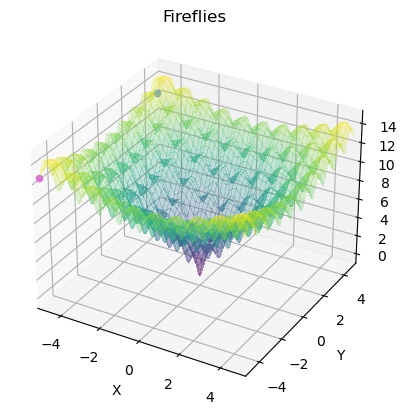

In [20]:
f = Fireflies(erkli, 0.2, 0.34, 1, 25, 5, -5, 5, -5, 5, minimize = True)
f.run_and_plot()

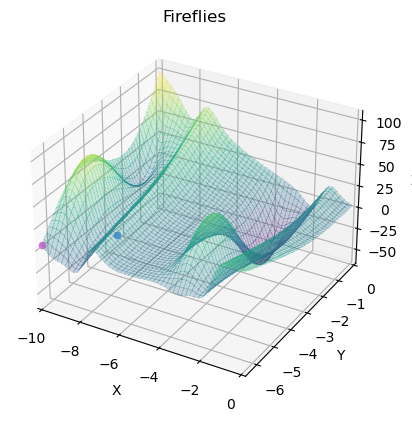

In [22]:
foxy = Fireflies(mishra_bird, 0.2, 0.34, 1, 25, 5, -10, 0, -6.5, 0)
foxy.run_and_plot()

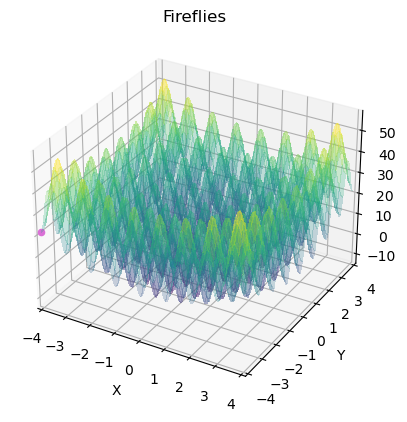

In [24]:
foxy1 = Fireflies(rastrigin, 0.2, 0.34, 1, 25, 5, -4, 4, -4, 4)
foxy1.run_and_plot()

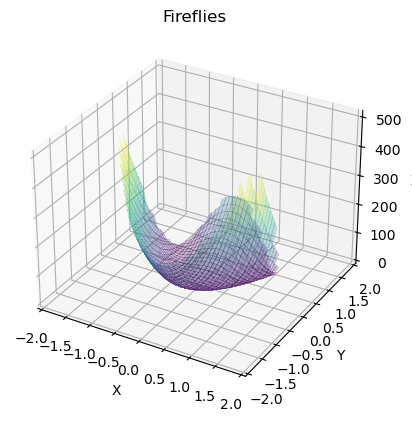

In [26]:
foxy2 = Fireflies(Rosenbrock, 0.2, 0.34, 1, 25, 5, -2, 2, -2, 2)
foxy2.run_and_plot()

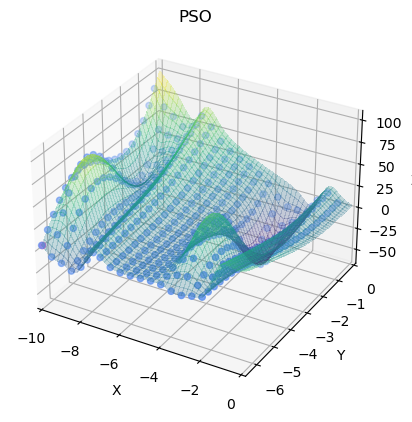

In [28]:
psoxy = PSO(mishra_bird, 80, 2, 2, 20, -1, 3,  -10, 0, -6.5, 0)
psoxy.run_and_plot()

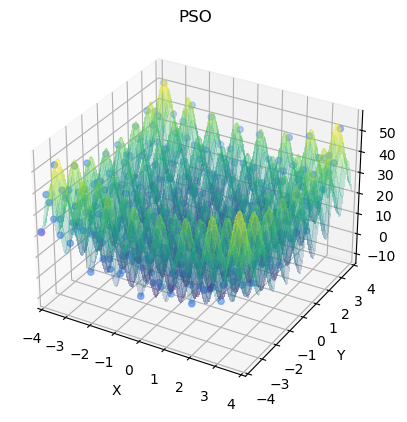

In [30]:
psoxy1 = PSO(rastrigin, 80, 2, 2, 20, -1, 3, -4, 4, -4, 4)
psoxy1.run_and_plot()

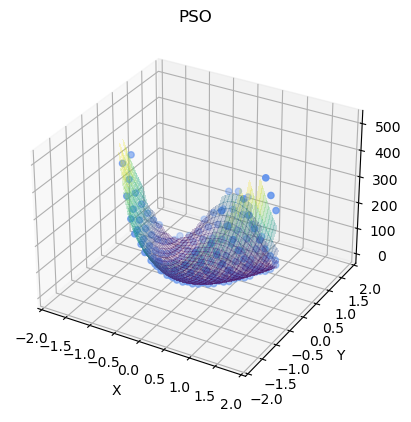

In [32]:
psoxy2 = PSO(Rosenbrock, 50, 2, 2, 20, -1, 3, -2, 2, -2, 2)
psoxy2.run_and_plot()

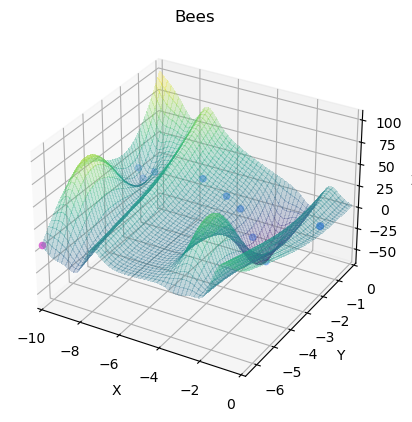

In [34]:
beexy = Bees(mishra_bird, 0.15, 0.34, 0.72, 50, 10, 3, 10, 5, 2, -10, 0, -6.5, 0)
beexy.run_and_plot()

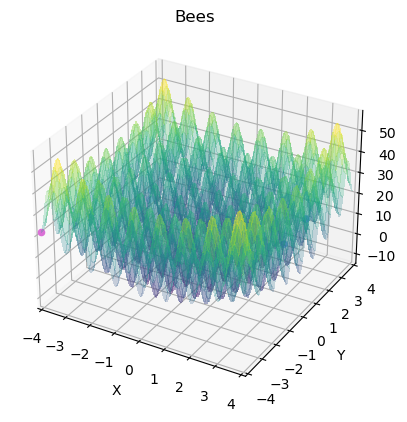

In [36]:
beexy1 = Bees(rastrigin, 0.15, 0.34, 0.72, 50, 10, 3, 10, 5, 2, -4, 4, -4, 4)
beexy1.run_and_plot()

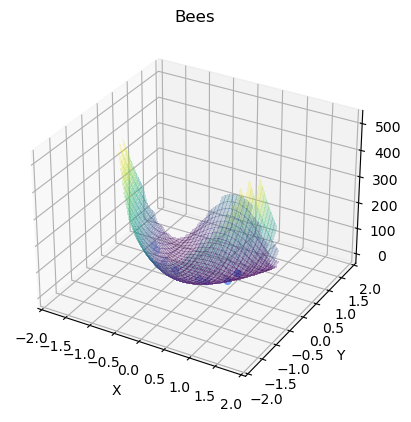

In [38]:
beexy2 = Bees(Rosenbrock, 0.15, 0.34, 0.72, 50, 10, 3, 10, 5, 2, -2, 2, -2, 2)
beexy2.run_and_plot()